# SI 618 Homework 5: Natural Language Processing

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

In [1]:
MY_UNIQNAME = 'tengdann'

# Download the data:
We will be using a subset of the data from [Project Gutenberg](http://www.gutenberg.org).

>Project Gutenberg is a volunteer effort to digitize and archive cultural works, to "encourage the creation and distribution of eBooks". It was founded in 1971 by American writer Michael S. Hart and is the oldest digital library. Most of the items in its collection are the full texts of public domain books. The project tries to make these as free as possible, in long-lasting, open formats that can be used on almost any computer., Project Gutenberg reached 57,000 items in its collection of free eBooks.

We will use a [cleaned up corpus](https://github.com/aparrish/gutenberg-dammit) that was processed by [Allison Parish](https://www.decontextualize.com/). This processing step was done to standardize metadata and text encoding. The dataset is described on the [project page](https://github.com/aparrish/gutenberg-dammit#gutenberg-dammit). Note that there are plain text files withing subdirectories numbered with the first three digits of the document ID, and there is also a JSON file of document metadata with title, author, and other information.


We created a reduced subset of 4000 documents for the purpose of this assignment that can be downloaded below:

https://drive.google.com/file/d/1V5ep_5veAccCD-YxGlVfv3DsXczBIvv5/view?usp=sharing

This ZIP file is approximately 550 MB compressed, and 1.45 GB uncompressed.

## Q1. (10 pts.) Data cleaning
- (3 pts.) Import the downloaded data
- (2 pts.) Convert to lowercase
- (2 pts.) Remove stopwords 
- (2 pts.) Remove punctuation and any other non-alphabet characters

In [37]:
import re
import os
import spacy
import logging
import gensim
from spacy.lang.en.stop_words import STOP_WORDS
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [50]:
folders = list(range(0, 2))
for i, folder in enumerate(folders):
    if len(str(folder)) == 1:
        folders[i] = '00' + str(folder)
    elif len(str(folder)) == 2:
        folders[i] = '0' + str(folder)
    else:
        folders[i] = str(folder)
        
# I only imported 2 total folders, given that throughout our entire assignment, we only use at most 5 books.
# The cost of importing all of the files is expensive; I assessed that it would be extraneous.
# To import all of the files, I would simply change the current range from range(0, 2) to range(0, 522).

_list = list()
for folder in folders:
    subfolder = './data/hw5_data/gutenberg-dammit-files/gutenberg-dammit-files/%s' % folder
    for file in os.listdir(subfolder):
        if re.search('\d+', file):
            filepath = os.path.join(subfolder, file)
            content = open(filepath, 'r', encoding = 'utf-8').read()
            df = pd.DataFrame(data = {'file': [file], 'content': [content]})
            _list.append(df)
            
raw_data = pd.concat(_list)
raw_data.reset_index(drop = True, inplace = True)
raw_data.head(10)

,file,content
0,00017.txt,THE BOOK OF MORMON\n\nAn Account Written\n\nBY...
1,00048.txt,THE WORLD FACTBOOK 1992\n\n\n:Afghanistan Geog...
2,00056.txt,When Senator Al Gore was evangelizing support ...
3,00064.txt,[Frontispiece: The cold hollow eye of a revolv...
4,00089.txt,"1. Except as provided in this Annex, each Pa..."
5,00091.txt,TOM SAWYER ABROAD\n\nBy Mark Twain\n\n\n\n\nCH...
6,00134.txt,CONTENTS\n\nPreface by William S. Godwin\n\nAu...
7,00137.txt,SARA CREWE\n\nOR\n\nWHAT HAPPENED AT MISS MINC...
8,00159.txt,THE ISLAND OF DOCTOR MOREAU\n\nby\nH. G. Wells...
9,00174.txt,The Picture of Dorian Gray\n\nby\n\nOscar Wild...


In [51]:
lower_data = raw_data.copy()
lower_data.content = lower_data.content.str.lower()
lower_data.head(10)

,file,content
0,00017.txt,the book of mormon\n\nan account written\n\nby...
1,00048.txt,the world factbook 1992\n\n\n:afghanistan geog...
2,00056.txt,when senator al gore was evangelizing support ...
3,00064.txt,[frontispiece: the cold hollow eye of a revolv...
4,00089.txt,"1. except as provided in this annex, each pa..."
5,00091.txt,tom sawyer abroad\n\nby mark twain\n\n\n\n\nch...
6,00134.txt,contents\n\npreface by william s. godwin\n\nau...
7,00137.txt,sara crewe\n\nor\n\nwhat happened at miss minc...
8,00159.txt,the island of doctor moreau\n\nby\nh. g. wells...
9,00174.txt,the picture of dorian gray\n\nby\n\noscar wild...


In [52]:
# nlp = spacy.load(r'C:\Users\dteng\Anaconda\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0')
nlp = spacy.load(r'C:\Users\mrasianman3\Anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0')
lower_nostop_data = lower_data.copy()
pat = r'\b(?:{})\b'.format('|'.join(list(STOP_WORDS)))
lower_nostop_data.content = lower_nostop_data.content.str.replace(pat, '')
lower_nostop_data.head(10)

,file,content
0,00017.txt,book mormon\n\n account written\n\n hand m...
1,00048.txt,world factbook 1992\n\n\n:afghanistan geograp...
2,00056.txt,senator al gore evangelizing support visio...
3,00064.txt,[frontispiece: cold hollow eye revolver sou...
4,00089.txt,"1. provided annex, party shall apply\n ..."
5,00091.txt,tom sawyer abroad\n\n mark twain\n\n\n\n\nchap...
6,00134.txt,contents\n\npreface william s. godwin\n\nauth...
7,00137.txt,sara crewe\n\n\n\n happened miss minchin's\n\...
8,00159.txt,island doctor moreau\n\n\nh. g. wells\n\n\n\...
9,00174.txt,picture dorian gray\n\n\n\noscar wilde\n\n\n...


In [53]:
lower_nostop_alpha_data = lower_nostop_data.copy()
pat = r'[\d!?.,\[\]/@#$%^&*():;\n\t]'
lower_nostop_alpha_data.content = lower_nostop_alpha_data.content.str.replace(pat, ' ')
lower_nostop_alpha_data.head(10)

,file,content
0,00017.txt,book mormon account written hand mormo...
1,00048.txt,world factbook afghanistan geography ...
2,00056.txt,senator al gore evangelizing support visio...
3,00064.txt,frontispiece cold hollow eye revolver sou...
4,00089.txt,provided annex party shall apply a...
5,00091.txt,tom sawyer abroad mark twain chapter t...
6,00134.txt,contents preface william s godwin author's...
7,00137.txt,sara crewe happened miss minchin's fra...
8,00159.txt,island doctor moreau h g wells cont...
9,00174.txt,picture dorian gray oscar wilde jtable ...


## Q2. (10 pts.) Frequency of Part of Speech (POS) tags
- Use spaCy
  - Use the original (or uncleaned) documents. spaCy does POS tagging better when the sentence is more complete. 
- (4 pts.) Extract POS tags from the first 100 sentences of selected 5 books. 
- (4 pts.) Plot the frequency of POS tags
- (2 pts.) Provide your interpretation

In [48]:
tokens = list()
for i in range(0,5):
    if len(lower_nostop_alpha_data.iloc[i].content) >= 1000000:
        doc = nlp(lower_nostop_alpha_data.iloc[i].content[:999999])
    else:
        doc = nlp(lower_nostop_alpha_data.iloc[i].content)
    
    sents = list()
    for i, sent in enumerate(doc.sents):
        if i < 100:
            sents.append(sent.text)
        else:
            break
    
    doc = nlp(' '.join(sents))
    for token in doc:
        try:
            tokens.append(token.pos_)
        except:
            pass

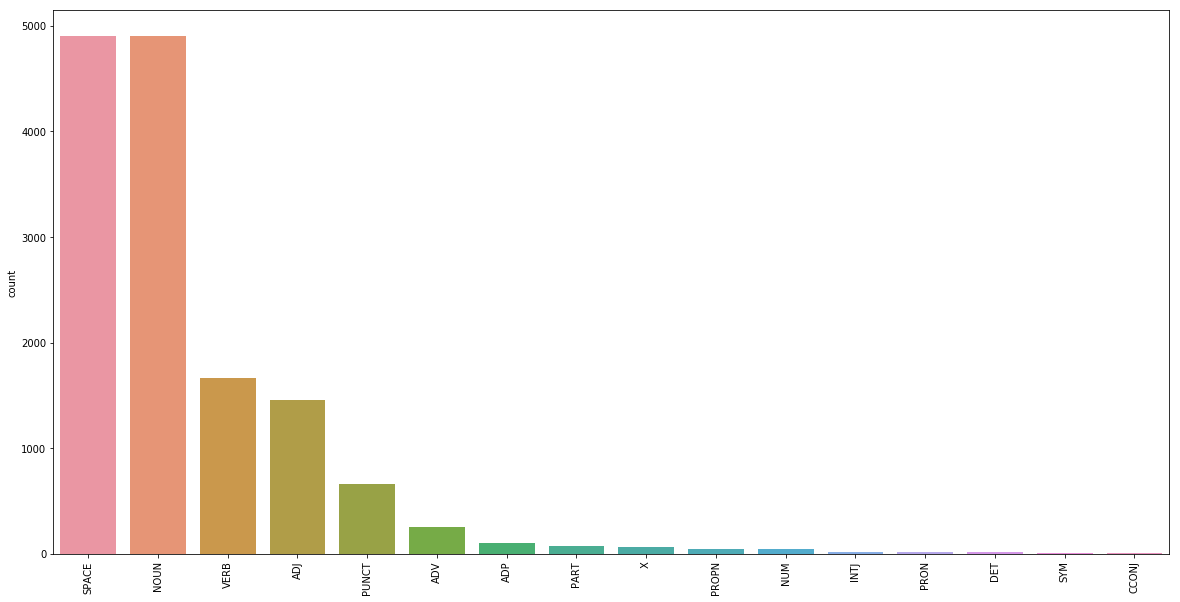

In [20]:
plt.figure(figsize=(20,10))
sns.countplot(tokens, order=pd.Series(tokens).value_counts().index)
# sns.countplot(words_nostop, order=[counted[0] for counted in Counter(words_nostop).most_common()])
plt.xticks(rotation=90)
plt.show()

Spacy tags spaces, so spaces being the most common tag is understandable; every book will have a space. Nouns being the **ACTUAL** most common is to be expected; English grammar dictates that nouns make a majority of sentences. Verbs and adjectives follow up; they are all used in conjunction with noungs. Punctuation follow at the end, since all sentences need to be ended with it.

## Q3. (10 pts.) Make wordclouds for 5 books
- Use the [```word_cloud```](https://github.com/amueller/word_cloud) package.
- (8 pts.) Create a wordcloud for 5 books that you choose.
  - The author of each book should be different.
- (2pts.) Provide your interpretation.

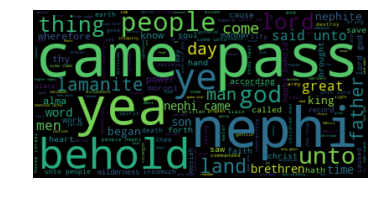

In [23]:
word_text = lower_nostop_alpha_data.copy()
word_text.content = word_text.content.str.replace('\n', '')

text = word_text.content[0]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

Since this book has religious context, the words yea, behold, and god are common words.

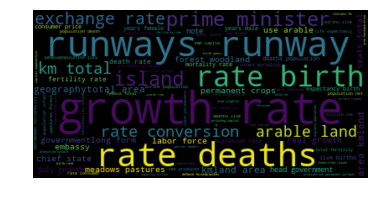

In [11]:
text = word_text.content[1]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This book is about Afghanistan; it is quite interesting that runway(s) have such a large presence. Given the constant involvement of major world powers in the region, it makes sense though.

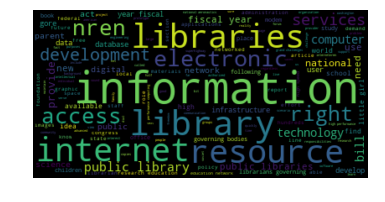

In [12]:
text = word_text.content[2]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This third book is about Al Gore's policies, regarding information. Thus, it makes sence information is the most common word seen. Other related words, such as library(ies), internet, and access are also very common.

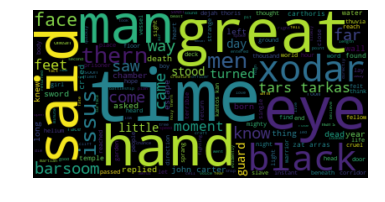

In [13]:
text = word_text.content[3]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This book is a novel; thus said and time are very common. Since it seems to be some sort of Western, words such as hand, great, and eye are common as well.

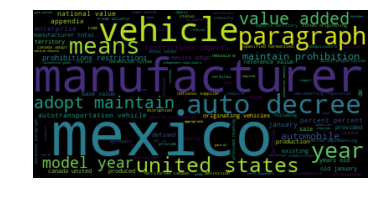

In [14]:
text = word_text.content[4]
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This seems to be a book about trade deals, focused on automobiles. Thus, Mexico, manufacturer, and vehicle are common as well.

## Q4. (bonus 5 pts.) Train your own word2vec vector.
- Use the ```gensim``` package
  - Your input will be the output from Q1 (cleaned data)
- Hint: You can look into this tutorial for training the new Word2Vec model: https://rare-technologies.com/word2vec-tutorial/
- Use default parameters when you train the Word2Vec model (e.g., ```min_count```, ```size```, etc.), except the number of workers (```workers=?```) parameter.
- Use this model for the later questions. 
  - **If you do not have your Word2Vec model, please use the pre-trained model that we used for the lab to answer the later questions**

In [24]:
class Sentences(object):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __iter__(self):
        sentences = list()
        for index, row in self.dataframe.iterrows():
            sentences = row.content.split('.')
            for sentence in sentences:
                yield gensim.utils.simple_preprocess(sentence)
                
sentences = Sentences(word_text)
model = gensim.models.Word2Vec(sentences, workers = 4)

## Q5. (15 pts.) Similarity from Word2Vec 
- Choose 5 words
- (5pts.) What are the top-10 similar words of each?
- (5pts.) Do you find anything odd or interesting? Please explanation. 
  - (if you have your own word2vec model)How the results are different from the pre-trained model that we used in the lab?

In [54]:
word = 'information'
print(f'The top-10 similar words to {word.upper()} are:')
similar = model.wv.most_similar(word)
for sim in similar:
    print(f'{sim[0]:<15} %.5f' % sim[1])

The top-10 similar words to INFORMATION are:
mind            0.99996
little          0.99995
maria           0.99995
got             0.99995
old             0.99995
new             0.99995
thought         0.99995
feet            0.99995
world           0.99995
long            0.99995


In [55]:
word = 'mexico'
print(f'The top-10 similar words to {word.upper()} are:')
similar = model.wv.most_similar(word)
for sim in similar:
    print(f'{sim[0]:<15} %.5f' % sim[1])

The top-10 similar words to MEXICO are:
manufacturer    0.99993
air             0.99991
old             0.99991
value           0.99991
half            0.99991
national        0.99991
head            0.99991
mind            0.99991
sand            0.99990
little          0.99990


In [56]:
word = 'time'
print(f'The top-10 similar words to {word.upper()} are:')
similar = model.wv.most_similar(word)
for sim in similar:
    print(f'{sim[0]:<15} %.5f' % sim[1])

The top-10 similar words to TIME are:
thought         0.99999
thing           0.99999
place           0.99999
like            0.99998
way             0.99998
long            0.99998
day             0.99998
eyes            0.99998
turned          0.99998
heart           0.99998


In [60]:
word = 'growth'
print(f'The top-10 similar words to {word.upper()} are:')
similar = model.wv.most_similar(word)
for sim in similar:
    print(f'{sim[0]:<15} %.5f' % sim[1])

The top-10 similar words to GROWTH are:
july            0.99880
billion         0.99877
total           0.99869
million         0.99869
live            0.99859
death           0.99856
government      0.99855
years           0.99855
age             0.99849
production      0.99849


In [58]:
word = 'death'
print(f'The top-10 similar words to {word.upper()} are:')
similar = model.wv.most_similar(word)
for sim in similar:
    print(f'{sim[0]:<15} %.5f' % sim[1])

The top-10 similar words to DEATH are:
life            0.99990
old             0.99989
felt            0.99989
new             0.99989
right           0.99988
party           0.99988
black           0.99988
got             0.99988
mind            0.99988
little          0.99988


***TODO: Insert explanation***

## Q6. (20 pts.) Similarity between chapters 
- (5 pts.) Pick 5 chapters from the dataset and describe.
  - Each "chapter" consists of 10 consecutive paragraphs from a single book.
  - The author of each chapter should be different.
  - If necessary, explain how you defined "paragraph". 
- (5 pts.) Calculate the average of vectors for the words included in a chapter.  
  - In this way, you can have a vector that can roughly summarize the contents.    
  - The average vector should have the same dimensionality with word vectors 
    - e.g., if the word vector is a 100 dimension, the average vector for paragraph should be a 100 dimension as well
  - Words should come from the results of Q1 (cleaned out data) (i.e. should not contain stopwords or other special characters).
- (5 pts.) Calculate the similarity between chapters.  
  - Provide your interpretation. 
  - Why do you think some chapters are similar/dissimilar to others?

## Q7. (15 pts.) Word clustering
- Pick top-100 similar words with the word *information*.  
- Calculate cosine similarity scores between words
  - e.g., Create a 100x100 matrix that contains cosine similarity scores. Each row and columns should be words. 
- Use seaborn's [```.clustermap()```](https://seaborn.pydata.org/generated/seaborn.clustermap.html) function to draw a hierarchically-clustered heatmap
- Provide your interpretation

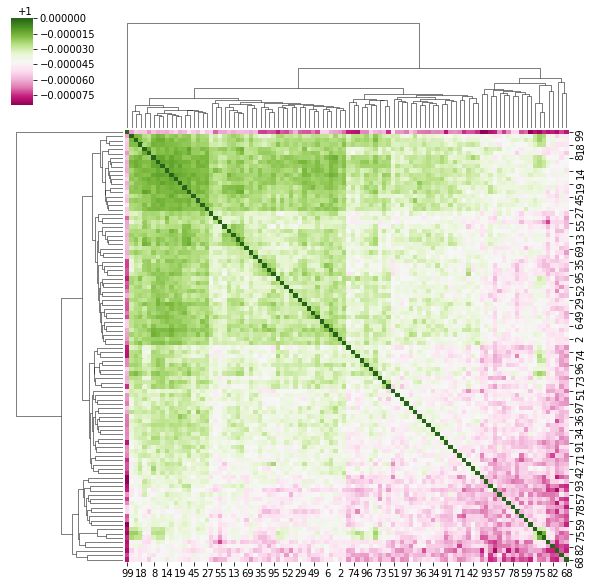

In [36]:
common = model.wv.most_similar('information', topn = 100)
matrix = list()
for word in common:
    row = list()
    for second in common:
        row.append(model.wv.similarity(word[0], second[0]))
        
    matrix.append(row)
    
sns.clustermap(matrix, cmap = 'PiYG')

***TODO: Insert explanation***